# GuillaumeNet

This is a implementation of http://arxiv.org/pdf/1511.00561v2.pdf (Except for the Upsampling layer where paper uses indices based upsampling which is not implemented in keras yet( *I am working on it*), but that shouldnt make a lot of difference)


### TODO

In [83]:
%matplotlib inline
import os
#pathToDataset = '/home/optimus/AI/work/modal/CamVid/'
os.environ['KERAS_BACKEND'] = 'theano'
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu0,floatX=float32,optimizer=fast_compile'
os.environ['THEANO_FLAGS']='device=gpu0,floatX=float32'
import cv2
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(1337) # for reproducibility
from keras.layers.noise import GaussianNoise
import keras.models as models

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import SGD

from keras.layers.normalization import BatchNormalization
from keras.regularizers import ActivityRegularizer
from keras import backend as K




In [84]:
Sky = [0,128,192]
Building = [64,64,64]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,128,128]
Pavement = [60,40,60]
Tree = [0,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [96,0,0]
Pedestrian = [255,0,0]
Bicyclist = [128,128,0]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])
label_names=['Sky','Building','Pole','Road','Pavement',
             'Tree' ,'SignSymbol' ,'Fence' ,'Car', 'Pedestrian', 'BiCyclist','Unlabelled']

# class weigths
class_weighting = [0.2595, 0.1826, 4.5640, 0.1417, 0.9051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]

## Data Fetching 
I equalized histograms of rbg layers separately, so that change in lighting doesnt effect the results.

In [93]:
with open(os.getcwd()+'/CamVid/train.txt') as f:
    train_img_list = f.readlines()
    train_img_list = [line.split(' ') for line in train_img_list]
        
with open(os.getcwd()+'/CamVid/test.txt') as f:
    test_img_list = f.readlines()
    test_img_list = [line.split(' ') for line in test_img_list]

def load_labels(typ,num):
    if(typ=='train'):
        return cv2.imread(os.getcwd() + train_img_list[num][1][7:][:-1])[:,:,0]
    elif(typ=='test'):
        return cv2.imread(os.getcwd() + test_img_list[num][1][7:][:-1])[:,:,0]

def load_img(typ,num):
    if(typ=='train'):
        return cv2.imread(os.getcwd() + train_img_list[num][0][7:])
    elif(typ=='test'):
        return cv2.imread(os.getcwd() + test_img_list[num][0][7:])

## Fixed variables

In [110]:
#  unchangeable variables
nb_training_examples = len(train_img_list)
nb_test_examples = len(test_img_list)

nb_classes=12
data_shape = 360*480

width=480
height=360

window_size=(50,50) #format width*height
pad=20
filtre_attribution_label = 0.85

## Fonctions de base

In [99]:
# fonctions 

def normalized(rgb):
    return rgb
    #return rgb/255.0
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0]=cv2.equalizeHist(b)
    norm[:,:,1]=cv2.equalizeHist(g)
    norm[:,:,2]=cv2.equalizeHist(r)

    return norm
   
def one_hot(n):
    a=np.zeros(nb_classes)
    a[n]=1
    return a

def attribuer_label_centre(labels,p=0.85):
    lab = labels[17:34,17:34]
    classes = [int(q) for q in lab.flatten()]
    hist = np.bincount(classes)
    hist = 1.0*hist/np.sum(hist)
    main_class = np.argmax(hist)
    if(hist[main_class]>p):
        return main_class
    else:
        return -1 # si ce n'est pas un bon exemple.
    
def attribuer_label_vote(labels, p):
    cl = [int(q) for q in labels.flatten()]
    cl = np.bincount(cl)
    cl = [cl[i]*np.sqrt(class_weighting[i]) for i in range(len(cl))]
    cl= cl/np.sum(cl) # vecteur de probabilité de chaque classe ! et oué
    main_class = np.argmax(cl) # probabilité d'appartenance à la classe dominante
    if(cl[main_class]>p):
        return main_class
    else:
        return -1
    
def prep_data(nb_images):
    print("Buiding dataset...")
    goodExample = 0
    train_data = []
    train_label = []
    for i in range(nb_images):
        print "Image n°",i
        labels = load_labels('train',i)
        img = load_img('train',i)
        
        for j in range(0,width-window_size[0],pad):
            for k in range(0,height-window_size[1],pad):
                classe = attribuer_label_centre(labels[k:k+window_size[1],j:j+window_size[0]],filtre_attribution_label)
                if (classe!=-1):
                    goodExample = goodExample + 1
                    window = img[k:k+window_size[1],j:j+window_size[0]] #fenetre glissante
                    train_data.append(normalized(window))
                    train_label.append(one_hot(classe))
                    
    print("Dataset built")
    print("Good examples =", goodExample)
    print("Classes :",label_names)
    print("Histogramme des classes : ",histoclass(train_label))
    return np.array(train_data), np.array(train_label)


def load_data():
    return (np.load('train_data'),np.load('train_label'))

def save_data(label, data, name="train"):
    np.save(name+'_data',data)
    np.save(name+'_label',label)

def histoclass(train_label):
    tab = [np.argmax(i) for i in train_label]
    return np.bincount(tab)
    
            

In [101]:
nb_images=20

img_data, img_label = prep_data(nb_images)

pctg_test = 20
nb_examples = len(img_data)
nb_test = int(np.floor(1.*pctg_test / 100. * nb_examples))

maPermutation = np.random.permutation(nb_examples)


test_label = img_label[maPermutation[:nb_test]]
test_data = img_data[maPermutation[:nb_test]]

train_label = img_label[maPermutation[nb_test:]]
train_data = img_data[maPermutation[nb_test:]]


print "Saving data"
save_data(train_label, train_data, "train")
save_data(test_label, test_data, "test")
print "Data saved"

Buiding dataset...
Image n° 0
Image n° 1
Image n° 2
Image n° 3
Image n° 4
Image n° 5
Image n° 6
Image n° 7
Image n° 8
Image n° 9
Image n° 10
Image n° 11
Image n° 12
Image n° 13
Image n° 14
Image n° 15
Image n° 16
Image n° 17
Image n° 18
Image n° 19
Dataset built
('Good examples =', 5070)
('Classes :', ['Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree', 'SignSymbol', 'Fence', 'Car', 'Pedestrian', 'BiCyclist', 'Unlabelled'])
('Histogramme des classes : ', array([ 978, 1151,    4,  871,  306,  884,   47,    0,  705,   11,    0,
        113]))
Saving data
Data saved


In [102]:
hc_train = histoclass(train_label)
hc_test = histoclass(test_label)
class_weighting = 1000./(hc_train+0.1)
print hc_train 
print hc_test

[792 917   4 694 256 688  39   0 564   8   0  94]
[186 234   0 177  50 196   8   0 141   3   0  19]


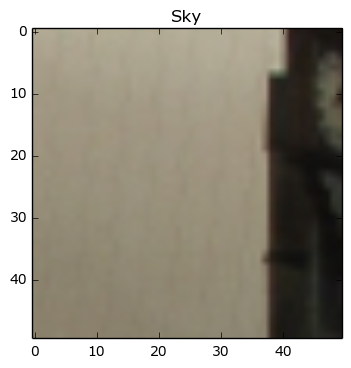

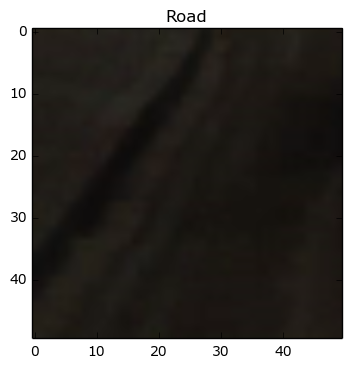

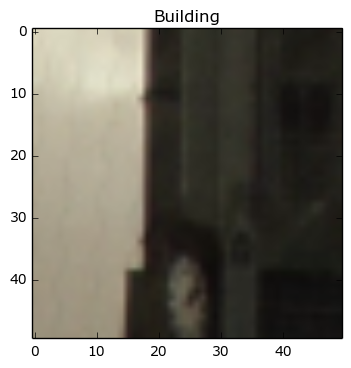

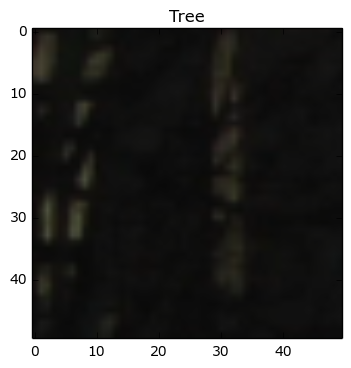

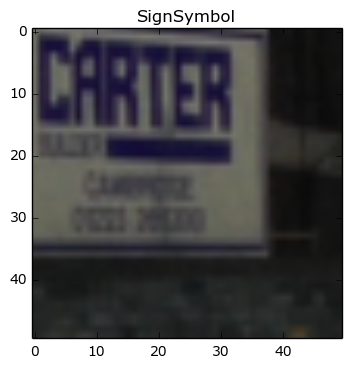

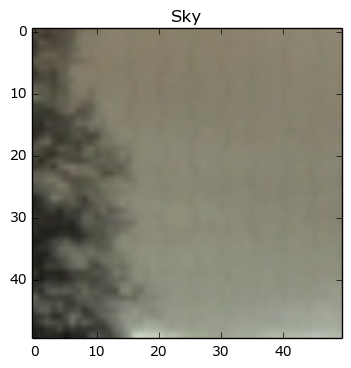

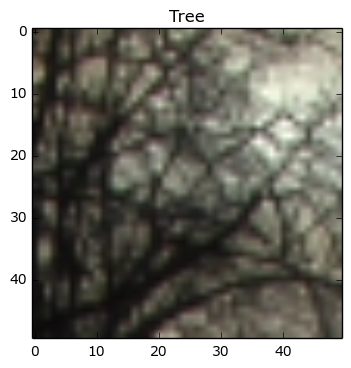

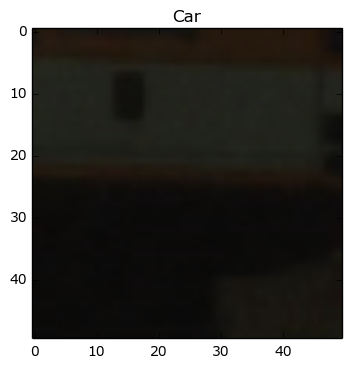

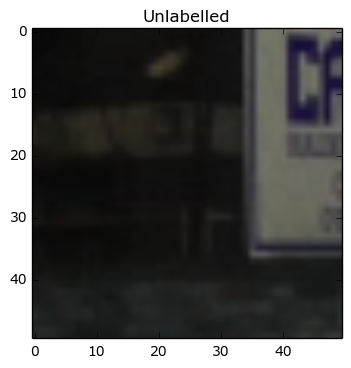

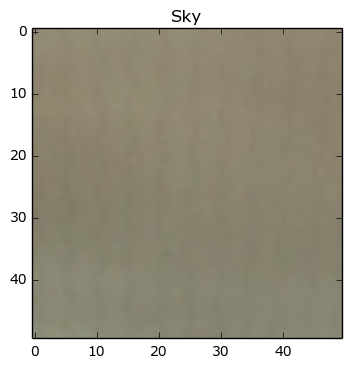

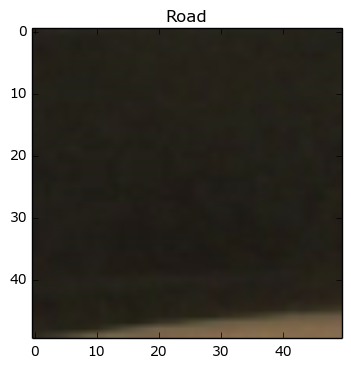

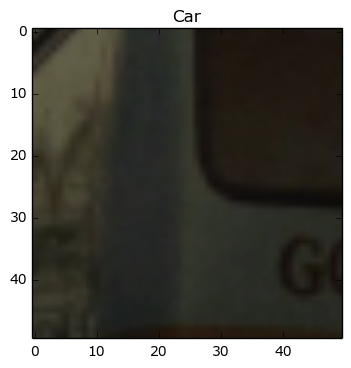

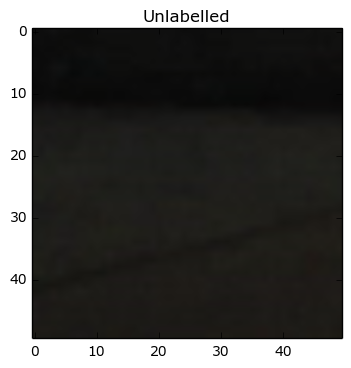

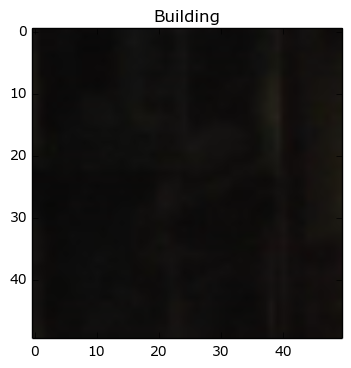

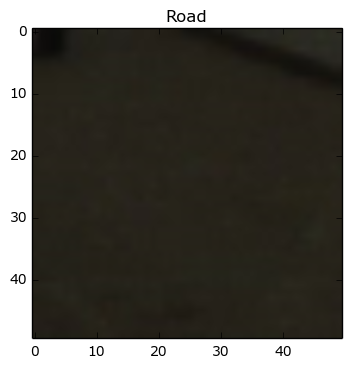

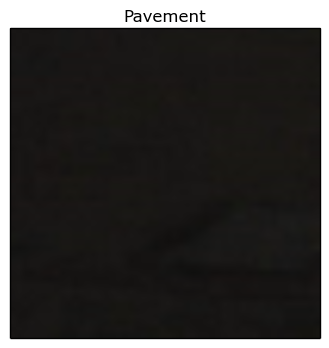

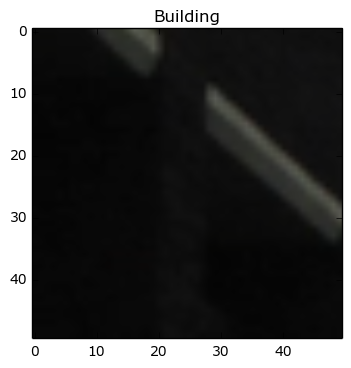

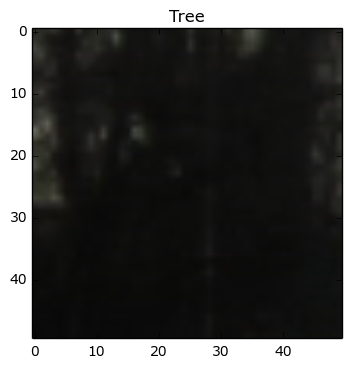

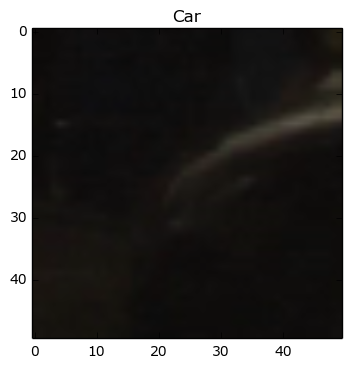

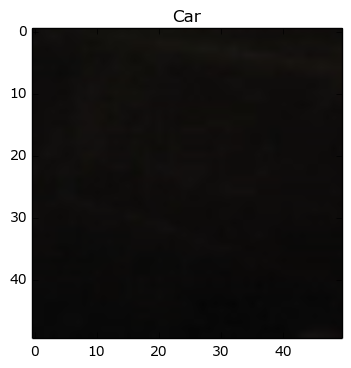

In [103]:
for i in range(220,240):
    plt.figure(i)
    plt.imshow(train_data[i])
    plt.title(label_names[np.argmax(train_label[i])])

#plt.imshow(train_data[1])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

### Creating and Compiling neuralnet

In [ ]:
def VGG_16(weights_path='vgg16_heights.h5'):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [104]:
def create_lenet()
    model1 = models.Sequential()

    model1.add(Convolution2D(20, 5, 5, border_mode="same",input_shape=(window_size[1], window_size[0],3)))
    model1.add(Activation("relu"))
    model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model1.add(Convolution2D(50, 5, 5, border_mode="same"))
    model1.add(Activation("relu"))
    model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model1.add(Flatten())
    model1.add(Dense(700))
    model1.add(Activation("relu"))

    # softmax classifier
    model1.add(Dense(nb_classes))
    model1.add(Activation("softmax"))
    return model1

#from keras.optimizers import SGD
optimizer = SGD(lr=0.00001, momentum=0.8, decay=0.01, nesterov=False)

#model=create_lenet()
model = VGG16() 
model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=['categorical_accuracy'])

In [105]:
nb_epoch = 30
batch_size = 250

history = model.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,class_weight=class_weighting)
#model1.save_weights('model_weights.hdf5')

Epoch 1/30
4056/4056 [==============================] - 3s - loss: 6.4051 - categorical_accuracy: 0.1802     
Epoch 2/30
4056/4056 [==============================] - 3s - loss: 3.2906 - categorical_accuracy: 0.2710     
Epoch 3/30
4056/4056 [==============================] - 3s - loss: 1.8244 - categorical_accuracy: 0.3585     
Epoch 4/30
4056/4056 [==============================] - 3s - loss: 1.6694 - categorical_accuracy: 0.3905     
Epoch 5/30
4056/4056 [==============================] - 3s - loss: 1.6029 - categorical_accuracy: 0.4095     
Epoch 6/30
4056/4056 [==============================] - 3s - loss: 1.5536 - categorical_accuracy: 0.4285     
Epoch 7/30
4056/4056 [==============================] - 3s - loss: 1.5193 - categorical_accuracy: 0.4369     
Epoch 8/30
4056/4056 [==============================] - 3s - loss: 1.4938 - categorical_accuracy: 0.4532     
Epoch 9/30
4056/4056 [==============================] - 3s - loss: 1.4708 - categorical_accuracy: 0.4645     
Epoch 10/3

In [106]:
score = model.evaluate(train_data,train_label, verbose=0)

print 'Train score:', score[0]
print 'Train accuracy:', score[1]

score = model.evaluate(test_data,test_label, verbose=0)

print 'Test score:', score[0]
print 'Test accuracy:', score[1]

Train score: 1.2880522577
Train accuracy: 0.553500986193
Test score: 1.26374304106
Test accuracy: 0.544378698225


### Visualization
I trained autoencoder sepeartely with 100 epochs, loading weights here.

In [ ]:
#model1.load_weights('model_weights.hdf5')

In [107]:
def pred(img): # prédiction sur une image
    result=np.zeros((360,480,12))
    out=np.zeros((360,480))
    for j in range(0,width-window_size[0],pad):
            for k in range(0,height-window_size[1],pad):
                window = img[k:k+window_size[1],j:j+window_size[0]]
                one_hot=model.predict_proba(np.array([window]),verbose=0)[0]
                a=np.zeros((window_size[1],window_size[0],12))
                a[:,:]=one_hot
                result[k:k+window_size[1],j:j+window_size[0]]+=a
    for i in range(360):
        for j in range(480):
            out[i,j]=np.argmax(result[i,j])
    return out
            
    
def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (1.0*r/255.0)#[:,:,0]
    rgb[:,:,1] = (1.0*g/255.0)#[:,:,1]
    rgb[:,:,2] = (1.0*b/255.0)#[:,:,2]
    return rgb

[]

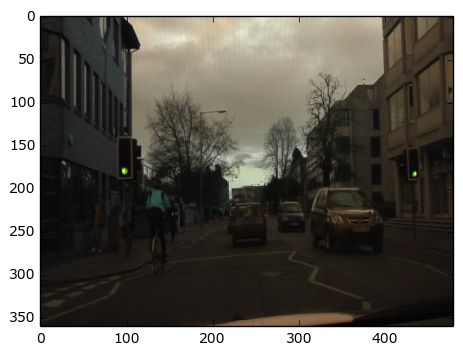

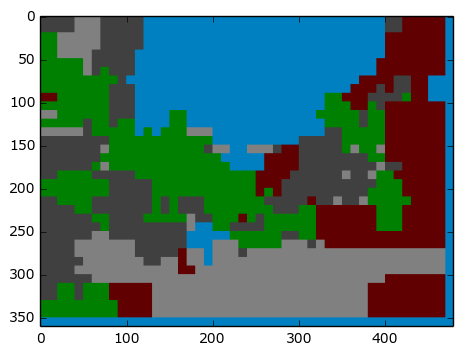

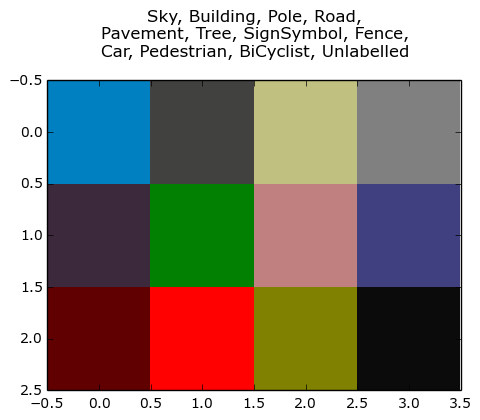

In [111]:
img_test = load_img('test',np.random.randint(nb_test_examples))
plt.imshow(img_test)

plt.figure(2)
prediction = pred(img_test)
plt.imshow(visualize(prediction))

plt.figure(3) # légende
leg=np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11]])
plt.imshow(visualize(leg), interpolation='none')
l=label_names
plt.title(l[0]+', '+l[1]+', '+l[2]+', '+l[3]+', \n'+l[4]+', '+l[5]+', '+l[6]+', '+l[7]+', \n'+l[8]+', '+l[9]+', '+l[10]+', '+l[11]+' \n')
plt.plot()

